Dataset information:
<xarray.Dataset> Size: 124MB
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 8B 2000-01-01
  * lon                    (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                    (lat) float32 2kB -59.88 -59.62 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] 16B ...
    Swnet_tavg             (time, lat, lon) float32 3MB ...
    Lwnet_tavg             (time, lat, lon) float32 3MB ...
    Qle_tavg               (time, lat, lon) float32 3MB ...
    Qh_tavg                (time, lat, lon) float32 3MB ...
    Qg_tavg                (time, lat, lon) float32 3MB ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 3MB ...
    Tair_f_inst            (time, lat, lon) float32 3MB ...
    Qair_f_inst            (time, lat, lon) float32 3MB ...
    Psurf_f_inst     

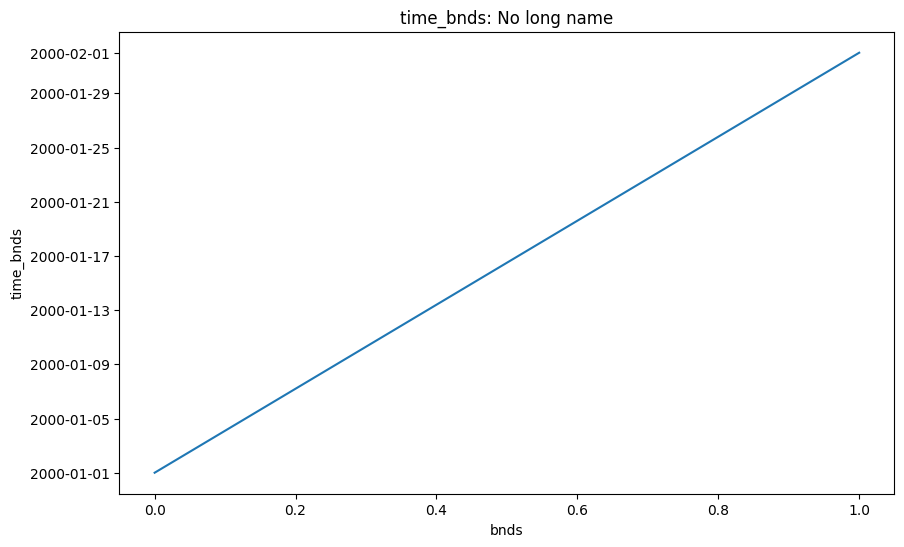

In [2]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

# Open the NetCDF file using xarray
ds = xr.open_dataset('../Data/data_GLDAS/GLDAS_NOAH025_M.A200001.021.nc4')

# Print basic information about the dataset
print("Dataset information:")
print(ds)

# Print the dimensions
print("\nDimensions:")
print(ds.dims)

# Print the variables
print("\nVariables:")
for var_name, var in ds.variables.items():
    print(f"{var_name}: {var.attrs.get('long_name', 'No long name')} - {var.dims} - {var.dtype}")

# Print global attributes
print("\nGlobal attributes:")
for attr_name, attr_value in ds.attrs.items():
    print(f"{attr_name}: {attr_value}")

# Get a sample variable to visualize (first variable with >= 2 dimensions)
sample_var = None
for var_name, var in ds.variables.items():
    if len(var.dims) >= 2:
        sample_var = var_name
        break

if sample_var:
    plt.figure(figsize=(10, 6))
    ds[sample_var].isel(time=0).plot()
    plt.title(f"{sample_var}: {ds[sample_var].attrs.get('long_name', 'No long name')}")
    plt.show()

Using soil moisture variable: RootMoist_inst


<Figure size 1200x800 with 0 Axes>

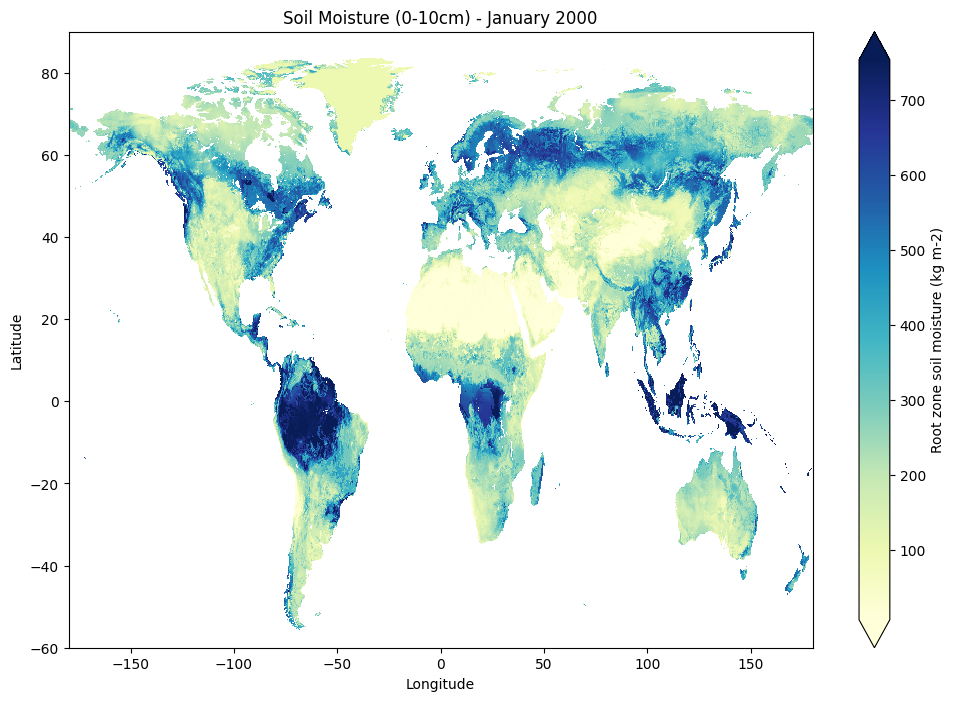

In [5]:
# Check if soil moisture variable for 0-10cm layer exists
sm_vars = [var for var in ds.variables if "moist" in var.lower() and "0_10" in var.lower() or "0-10" in var.lower()]

if sm_vars:
    sm_var = sm_vars[0]
    print(f"Found soil moisture variable: {sm_var}")
else:
    # If not explicitly named for 0-10cm, look for soil moisture variables with layer information
    sm_vars = [var for var in ds.variables if "moist" in var.lower() or "sm" == var.lower()]
    sm_var = sm_vars[0] if sm_vars else None
    print(f"Using soil moisture variable: {sm_var}")

if sm_var:
    plt.figure(figsize=(12, 8))
    # Plot the soil moisture map for the first time step
    sm_plot = ds[sm_var].isel(time=0).plot(
        cmap='YlGnBu', 
        robust=True,
        figsize=(12, 8),
        cbar_kwargs={'label': f'{ds[sm_var].attrs.get("long_name", sm_var)} ({ds[sm_var].attrs.get("units", "unknown units")})'}
    )
    plt.title(f'Soil Moisture (0-10cm) - January 2000')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("No soil moisture variable found in the dataset. Available variables are:")
    for var_name in ds.variables:
        print(f"- {var_name}: {ds[var_name].attrs.get('long_name', 'No long name')}")


In [3]:
import xarray as xr
import pandas as pd
from pathlib import Path
import os # Included for basic path joining if needed, but pathlib is preferred

# --- Configuration ---
# Specify the folder containing your NetCDF files
# data_folder = Path('../Data/data_GLDAS/') 
# OR use an absolute path if needed:
data_folder = Path('../Data/data_GLDAS') # IMPORTANT: Change this path!

# Specify the file pattern to search for
file_pattern = '*.nc4' 

# --- Function to find the soil moisture variable ---
def find_soil_moisture_variable(ds):
    """
    Attempts to find the soil moisture variable name in the dataset.
    Prioritizes known GLDAS 0-10cm name, then specific patterns, then general ones.
    """
    variables = ds.variables
    var_names = [var.lower() for var in variables] # Lowercase for case-insensitive search

    # Priority 1: Known specific GLDAS name for 0-10cm
    known_name = 'SoilMoi0_10cm_inst'
    if known_name in variables:
        print(f"Found standard variable: {known_name}")
        return known_name
    if known_name.lower() in var_names:
        # Find the original case version
        original_case_var = [var for var in variables if var.lower() == known_name.lower()][0]
        print(f"Found standard variable (case-insensitive): {original_case_var}")
        return original_case_var

    # Priority 2: Explicitly named for 0-10cm layer (using original logic, corrected)
    sm_vars_0_10 = [
        var for var in variables 
        if "moist" in var.lower() and ("0_10" in var.lower() or "0-10" in var.lower())
    ]
    if sm_vars_0_10:
        selected_var = sm_vars_0_10[0]
        if len(sm_vars_0_10) > 1:
            print(f"Warning: Found multiple potential 0-10cm variables: {sm_vars_0_10}. Using first: {selected_var}")
        else:
            print(f"Found 0-10cm soil moisture variable by pattern: {selected_var}")
        return selected_var

    # Priority 3: General soil moisture variable names (fallback)
    sm_vars_general = [
        var for var in variables 
        if "moist" in var.lower() or "sm" == var.lower() # exact 'sm' or contains 'moist'
    ]
    if sm_vars_general:
        selected_var = sm_vars_general[0]
        # Try to find one with fewest dimensions if multiple exist (often the surface layer)
        min_dims = 1000
        for var_name in sm_vars_general:
            if len(ds[var_name].dims) < min_dims:
                min_dims = len(ds[var_name].dims)
                selected_var = var_name
                
        print(f"Warning: No explicit 0-10cm variable found. Using fallback: {selected_var}")
        if len(sm_vars_general) > 1:
             print(f"   (Found multiple general SM variables: {sm_vars_general}. Selected '{selected_var}' based on dimensions.)")
        return selected_var

    # If no variable is found
    return None




# --- Main Script ---
all_dataframes = [] # List to hold DataFrames from each file

print(f"Searching for files matching '{file_pattern}' in folder: {data_folder}")

# Check if the folder exists
if not data_folder.is_dir():
    print(f"Error: Folder not found at {data_folder}")
    exit()

# load the first file to create a canada mask
example_file = xr.open_dataset('../Data/data_GLDAS/GLDAS_NOAH025_M.A200001.021.nc4')
# Create a mask for Canada (assuming lat/lon coordinates)

mask = (example_file['lat'] >= 41) & (example_file['lat'] <= 83) & (example_file['lon'] >= -141) & (example_file['lon'] <= -52)


# Iterate through files in the specified folder
counter = 0
for filepath in data_folder.glob(file_pattern):
    print(f"\nProcessing file: {filepath.name}")
    
    try:
        # Open the dataset using a 'with' statement for automatic closing
        with xr.open_dataset(filepath) as ds:
            #apply the mask to the dataset
            ds = ds.where(mask, drop=False)
            
            # Find the soil moisture variable
            sm_var_name = find_soil_moisture_variable(ds)

            if sm_var_name:
                # Select the soil moisture variable
                sm_data = ds[sm_var_name]

                # Convert the DataArray to a Pandas DataFrame
                # This automatically includes coordinates (time, lat, lon) as multi-index
                df_temp = sm_data.to_dataframe(name='soil_moisture') # Rename data column

                # Reset index to make time, lat, lon regular columns
                df_temp = df_temp.reset_index()

                # Append the DataFrame to our list
                all_dataframes.append(df_temp)
                print(f"Successfully extracted data for variable '{sm_var_name}'.")

            else:
                print(f"Warning: No suitable soil moisture variable found in {filepath.name}. Skipping file.")
                print("  Available variables:")
                for var_name in ds.variables:
                   print(f"  - {var_name}: {ds[var_name].attrs.get('long_name', 'No long name')}")


    except Exception as e:
        print(f"Error processing file {filepath.name}: {e}")
        # Decide if you want to stop or continue with other files
        # continue # Uncomment to skip problematic files and continue
    counter += 1
    if counter > 20:
        print("Stopping after 100 files for demonstration purposes.")
        break


# Concatenate all individual DataFrames into one large DataFrame
if all_dataframes:
    print("\nConcatenating data from all files...")
    final_df = pd.concat(all_dataframes, ignore_index=True)

    print("\nFinal DataFrame Info:")
    final_df.info()

    print("\nFinal DataFrame Head:")
    print(final_df.head())

    print("\nFinal DataFrame Tail:")
    print(final_df.tail())
    
    # --- Optional: Save the final DataFrame ---
    # output_filename = data_folder / "compiled_soil_moisture.csv"
    # print(f"\nSaving compiled data to {output_filename}...")
    # final_df.to_csv(output_filename, index=False) 
    # For very large data, consider Feather or Parquet for efficiency:
    # output_filename_feather = data_folder / "compiled_soil_moisture.feather"
    # final_df.to_feather(output_filename_feather)
    # print("Save complete.")

else:
    print("\nNo data was extracted. The list of DataFrames is empty.")
    print("Please check the folder path, file pattern, and variable names within the files.")

print("\nScript finished.")

Searching for files matching '*.nc4' in folder: ../Data/data_GLDAS

Processing file: GLDAS_NOAH025_M.A201902.021.nc4
Found standard variable: SoilMoi0_10cm_inst
Successfully extracted data for variable 'SoilMoi0_10cm_inst'.

Processing file: GLDAS_NOAH025_M.A201301.021.nc4
Found standard variable: SoilMoi0_10cm_inst
Successfully extracted data for variable 'SoilMoi0_10cm_inst'.

Processing file: GLDAS_NOAH025_M.A200803.021.nc4
Found standard variable: SoilMoi0_10cm_inst
Successfully extracted data for variable 'SoilMoi0_10cm_inst'.

Processing file: GLDAS_NOAH025_M.A201405.021.nc4
Found standard variable: SoilMoi0_10cm_inst
Successfully extracted data for variable 'SoilMoi0_10cm_inst'.

Processing file: GLDAS_NOAH025_M.A200212.021.nc4
Found standard variable: SoilMoi0_10cm_inst
Successfully extracted data for variable 'SoilMoi0_10cm_inst'.

Processing file: GLDAS_NOAH025_M.A200104.021.nc4
Found standard variable: SoilMoi0_10cm_inst
Successfully extracted data for variable 'SoilMoi0_10c

In [4]:
# safe the df as csv
final_df.to_csv('compiled_soil_moisture.csv', index=False)

In [7]:
import xarray as xr
import pandas as pd
from pathlib import Path
import os # Included for basic path joining if needed, but pathlib is preferred
import warnings # To suppress potential warnings during concatenation if needed

# --- Configuration ---
# Specify the folder containing your NetCDF files
# data_folder = Path('../Data/data_GLDAS/') 
# OR use an absolute path if needed:
# data_folder = Path('/path/to/your/Data/data_GLDAS') # IMPORTANT: Change this path!
data_folder = Path('../Data/data_GLDAS') # Using relative path as in the example

# Specify the file pattern to search for
file_pattern = '*.nc4' 

# Define approximate geographic bounds for Canada
lat_min, lat_max = 41.0, 83.0
lon_min, lon_max = -141.0, -52.0

# --- Function to find ALL soil moisture variables ---
def find_all_soil_moisture_variables(ds):
    """
    Attempts to find *all* soil moisture variable names in the dataset.
    Looks for 'moist' in the name (case-insensitive) or exact name 'sm'.
    """
    variables = ds.variables
    sm_vars = [
        var for var in variables 
        if 'moist' in var.lower() or 'sm' == var.lower() # Add other keywords if needed, e.g., 'soilwater'
    ]
    
    if sm_vars:
        print(f"Found soil moisture variables: {sm_vars}")
    else:
        print("No soil moisture variables found based on criteria.")
        
    return sm_vars

# --- Main Script ---
all_dataframes = [] # List to hold DataFrames from each file

print(f"Searching for files matching '{file_pattern}' in folder: {data_folder}")

# Check if the folder exists
if not data_folder.is_dir():
    print(f"Error: Folder not found at {data_folder}")
    exit()

# --- Create the Canada mask ---
# Need to load one file just to get the coordinates for the mask
try:
    # Find the first file matching the pattern to create the mask
    first_file = next(data_folder.glob(file_pattern), None)
    if first_file is None:
        print(f"Error: No files matching '{file_pattern}' found in {data_folder} to create mask.")
        exit()
        
    print(f"Using file '{first_file.name}' to create coordinate mask.")
    with xr.open_dataset(first_file) as ds_example:
        # Ensure lat/lon coordinates exist
        if 'lat' not in ds_example.coords or 'lon' not in ds_example.coords:
             print(f"Error: 'lat' or 'lon' coordinates not found in example file {first_file.name}")
             exit()
        # Create the boolean mask based on coordinates
        canada_mask = (
            (ds_example['lat'] >= lat_min) & (ds_example['lat'] <= lat_max) &
            (ds_example['lon'] >= lon_min) & (ds_example['lon'] <= lon_max)
        )
        # Check if the mask is empty (e.g., bounds are outside data range)
        if not canada_mask.any():
             print("Warning: The defined Canada bounds result in an empty mask for the example file's coordinates.")
             # Decide whether to exit or continue (continuing might result in no data)
             # exit() 
             
except Exception as e:
    print(f"Error creating Canada mask from file {first_file.name}: {e}")
    exit()

# --- Iterate through files and process data ---
# limit_files = 20 # Set a limit for testing, set to None for processing all files
limit_files = None # Process all files

file_counter = 0
processed_files_count = 0

for filepath in data_folder.glob(file_pattern):
    if limit_files is not None and file_counter >= limit_files:
        print(f"\nStopping after processing {limit_files} files (limit is set).")
        break
        
    file_counter += 1
    print(f"\nProcessing file {file_counter}: {filepath.name}")
    
    try:
        # Open the dataset using a 'with' statement for automatic closing
        with xr.open_dataset(filepath) as ds:
            
            # Check coordinate consistency before applying mask (optional but good practice)
            if not ds.coords['lat'].equals(ds_example.coords['lat']) or \
               not ds.coords['lon'].equals(ds_example.coords['lon']):
                print(f"Warning: Coordinates in {filepath.name} differ from the mask's base file. Skipping mask application or re-creating mask might be needed.")
                # Handle this case: skip file, re-create mask, or proceed with caution
                # For now, we proceed assuming coordinates match GLDAS standard grid
            
            # Apply the Canada mask
            # Using drop=False initially keeps original grid size but NaNs outside mask.
            # We will drop NaN rows later in pandas for efficiency.
            # Alternatively, use drop=True here: ds = ds.where(canada_mask, drop=True)
            # which might be more memory efficient for xarray operations but less flexible.
            ds_masked = ds.where(canada_mask, drop=False) 
            
            # Find all soil moisture variables in the masked dataset
            sm_var_names = find_all_soil_moisture_variables(ds_masked)

            if sm_var_names:
                # Select only the soil moisture variables
                ds_sm_only = ds_masked[sm_var_names]

                # Convert the selected DataArrays to a single Pandas DataFrame
                # This automatically includes coordinates (time, lat, lon) as multi-index
                # and creates columns for each variable in sm_var_names
                df_temp = ds_sm_only.to_dataframe() 

                # Reset index to make time, lat, lon regular columns
                df_temp.reset_index(inplace=True)

                # CRITICAL: Drop rows where ALL extracted soil moisture variables are NaN.
                # This effectively removes grid cells outside the Canada mask.
                df_temp.dropna(subset=sm_var_names, how='all', inplace=True)

                if not df_temp.empty:
                    # Append the DataFrame (containing only Canadian data) to our list
                    all_dataframes.append(df_temp)
                    print(f"Successfully extracted {len(sm_var_names)} SM variables for Canada region.")
                    processed_files_count += 1
                else:
                    print("Dataframe is empty after masking and NaN drop (no valid SM data in Canada region for this file).")


            else:
                print(f"Warning: No soil moisture variables found in {filepath.name} after masking (or originally). Skipping file.")
                # You could list variables from the *original* ds here if needed for debugging
                # print("  Available variables in original dataset:")
                # for var_name in ds.variables:
                #    print(f"  - {var_name}")
            if processed_files_count > 20:
                print("Stopping after 20 files for demonstration purposes.")
                break

    except Exception as e:
        print(f"Error processing file {filepath.name}: {e}")
        # Decide if you want to stop or continue with other files
        # continue # Uncomment to skip problematic files and continue

# --- Concatenate and Finalize ---
if all_dataframes:
    print(f"\nConcatenating data from {processed_files_count} successfully processed files...")
    # Suppress warnings about potentially different dtypes if columns match but had NaNs differently
    with warnings.catch_warnings():
         warnings.simplefilter("ignore", category=FutureWarning) # Catches some concat warnings
         final_df = pd.concat(all_dataframes, ignore_index=True)

    print("\nFinal DataFrame Info:")
    final_df.info(verbose=True, show_counts=True) # More detailed info

    print("\nFinal DataFrame Head:")
    print(final_df.head())

    print("\nFinal DataFrame Tail:")
    print(final_df.tail())

    # --- Optional: Save the final DataFrame ---
    # Ensure the output folder exists if saving
    output_folder = Path('./output') # Save in a subfolder named 'output'
    output_folder.mkdir(parents=True, exist_ok=True) 
    
    # output_filename_csv = output_folder / "compiled_canada_soil_moisture.csv"
    # print(f"\nSaving compiled data to {output_filename_csv}...")
    # final_df.to_csv(output_filename_csv, index=False) 
    
    # For very large data, Feather or Parquet are recommended
    output_filename_feather = output_folder / "compiled_canada_soil_moisture.csv"
    print(f"\nSaving compiled data to {output_filename_feather}...")
    final_df.to_csv(output_filename_feather)
    print("Save complete.")


else:
    print(f"\nNo data was extracted after processing {file_counter} files.")
    print("Please check:")
    print("  - The folder path and file pattern.")
    print("  - If files actually contain soil moisture variables matching the criteria ('moist', 'sm').")
    print("  - If the Canada geographic bounds overlap with the data coordinates.")
    print("  - If any errors occurred during file processing.")

print("\nScript finished.")

Searching for files matching '*.nc4' in folder: ../Data/data_GLDAS
Using file 'GLDAS_NOAH025_M.A201902.021.nc4' to create coordinate mask.

Processing file 1: GLDAS_NOAH025_M.A201902.021.nc4
Found soil moisture variables: ['RootMoist_inst']
Successfully extracted 1 SM variables for Canada region.

Processing file 2: GLDAS_NOAH025_M.A201301.021.nc4
Found soil moisture variables: ['RootMoist_inst']
Successfully extracted 1 SM variables for Canada region.

Processing file 3: GLDAS_NOAH025_M.A200803.021.nc4
Found soil moisture variables: ['RootMoist_inst']
Successfully extracted 1 SM variables for Canada region.

Processing file 4: GLDAS_NOAH025_M.A201405.021.nc4
Found soil moisture variables: ['RootMoist_inst']
Successfully extracted 1 SM variables for Canada region.

Processing file 5: GLDAS_NOAH025_M.A200212.021.nc4
Found soil moisture variables: ['RootMoist_inst']
Successfully extracted 1 SM variables for Canada region.

Processing file 6: GLDAS_NOAH025_M.A200104.021.nc4
Found soil moi

In [8]:
import xarray as xr
import pandas as pd
from pathlib import Path
import os # Included for basic path joining if needed, but pathlib is preferred
import warnings # To suppress potential warnings during concatenation if needed

# --- Configuration ---
# Specify the folder containing your NetCDF files
# data_folder = Path('../Data/data_GLDAS/') 
# OR use an absolute path if needed:
# data_folder = Path('/path/to/your/Data/data_GLDAS') # IMPORTANT: Change this path!
data_folder = Path('../Data/data_GLDAS') # Using relative path as in the example

# Specify the file pattern to search for
file_pattern = '*.nc4' 

# Define approximate geographic bounds for Canada
lat_min, lat_max = 41.0, 83.0
lon_min, lon_max = -141.0, -52.0

# --- Define EXACT soil moisture variables to extract ---
TARGET_SM_VARIABLES = [
    'SoilMoi0_10cm_inst', 
    'SoilMoi10_40cm_inst', 
    'SoilMoi40_100cm_inst', 
    'SoilMoi100_200cm_inst'
]

# --- Main Script ---
all_dataframes = [] # List to hold DataFrames from each file

print(f"Searching for files matching '{file_pattern}' in folder: {data_folder}")
print(f"Target variables: {TARGET_SM_VARIABLES}")

# Check if the folder exists
if not data_folder.is_dir():
    print(f"Error: Folder not found at {data_folder}")
    exit()

# --- Create the Canada mask ---
# Need to load one file just to get the coordinates for the mask
try:
    # Find the first file matching the pattern to create the mask
    first_file = next(data_folder.glob(file_pattern), None)
    if first_file is None:
        print(f"Error: No files matching '{file_pattern}' found in {data_folder} to create mask.")
        exit()
        
    print(f"Using file '{first_file.name}' to create coordinate mask.")
    with xr.open_dataset(first_file) as ds_example:
        # Ensure lat/lon coordinates exist
        if 'lat' not in ds_example.coords or 'lon' not in ds_example.coords:
             print(f"Error: 'lat' or 'lon' coordinates not found in example file {first_file.name}")
             exit()
        # Create the boolean mask based on coordinates
        canada_mask = (
            (ds_example['lat'] >= lat_min) & (ds_example['lat'] <= lat_max) &
            (ds_example['lon'] >= lon_min) & (ds_example['lon'] <= lon_max)
        )
        # Check if the mask is empty (e.g., bounds are outside data range)
        if not canada_mask.any():
             print("Warning: The defined Canada bounds result in an empty mask for the example file's coordinates.")
             # Decide whether to exit or continue (continuing might result in no data)
             # exit() 
             
except Exception as e:
    print(f"Error creating Canada mask from file {first_file.name}: {e}")
    exit()

# --- Iterate through files and process data ---
# limit_files = 20 # Set a limit for testing, set to None for processing all files
limit_files = None # Process all files

file_counter = 0
processed_files_count = 0 # Counts files from which data was actually extracted

for filepath in data_folder.glob(file_pattern):
    # Apply the overall file limit if set
    if limit_files is not None and file_counter >= limit_files:
        print(f"\nStopping file iteration after attempting {limit_files} files (limit is set).")
        break
        
    file_counter += 1
    print(f"\nProcessing file {file_counter}: {filepath.name}")
    
    # --- Added limit based on successfully processed files as per user's last code ---
    # Note: This check is now inside the loop, matching the user's previous logic placement.
    # It will stop *after* processing the 21st successful file.
    if processed_files_count > 20: 
        print(f"Stopping after successfully processing {processed_files_count-1} files (limit reached).")
        break
    # --- End of added limit ---

    try:
        # Open the dataset using a 'with' statement for automatic closing
        with xr.open_dataset(filepath) as ds:
            
            # Check coordinate consistency before applying mask (optional but good practice)
            if not ds.coords['lat'].equals(ds_example.coords['lat']) or \
               not ds.coords['lon'].equals(ds_example.coords['lon']):
                print(f"Warning: Coordinates in {filepath.name} differ from the mask's base file. Skipping mask application or re-creating mask might be needed.")
                # Handle this case: skip file, re-create mask, or proceed with caution
                # For now, we proceed assuming coordinates match GLDAS standard grid
            
            # Apply the Canada mask
            ds_masked = ds.where(canada_mask, drop=False) 
            
            # --- Check which of the TARGET variables are present in this file ---
            present_sm_vars = [var for var in TARGET_SM_VARIABLES if var in ds_masked.variables]
            
            if present_sm_vars:
                print(f"  Found present target variables: {present_sm_vars}")
                # Select only the soil moisture variables that are present
                ds_sm_selected = ds_masked[present_sm_vars]

                # Convert the selected DataArrays to a single Pandas DataFrame
                df_temp = ds_sm_selected.to_dataframe() 

                # Reset index to make time, lat, lon regular columns
                df_temp.reset_index(inplace=True)

                # CRITICAL: Drop rows where ALL the *present* soil moisture variables are NaN.
                # This effectively removes grid cells outside the Canada mask.
                df_temp.dropna(subset=present_sm_vars, how='all', inplace=True)

                if not df_temp.empty:
                    # Append the DataFrame (containing only Canadian data) to our list
                    all_dataframes.append(df_temp)
                    print(f"  Successfully extracted {len(present_sm_vars)} SM variables for Canada region.")
                    processed_files_count += 1 # Increment count of successfully processed files
                else:
                    print("  Dataframe is empty after masking and NaN drop (no valid SM data in Canada region for this file).")

            else:
                # This case means *none* of the TARGET_SM_VARIABLES were found in this file
                print(f"Warning: None of the target soil moisture variables ({TARGET_SM_VARIABLES}) found in {filepath.name}. Skipping file.")


    except Exception as e:
        print(f"Error processing file {filepath.name}: {e}")
        # Decide if you want to stop or continue with other files
        # continue # Uncomment to skip problematic files and continue


# --- Concatenate and Finalize ---
if all_dataframes:
    print(f"\nConcatenating data from {processed_files_count} successfully processed files...")
    # Suppress warnings about potentially different dtypes if columns match but had NaNs differently
    with warnings.catch_warnings():
         warnings.simplefilter("ignore", category=FutureWarning) # Catches some concat warnings
         # Concatenation naturally handles missing columns by filling with NaN
         final_df = pd.concat(all_dataframes, ignore_index=True)

    print("\nFinal DataFrame Info:")
    final_df.info(verbose=True, show_counts=True) # More detailed info

    print("\nFinal DataFrame Head:")
    print(final_df.head())

    print("\nFinal DataFrame Tail:")
    print(final_df.tail())

    # --- Save the final DataFrame as CSV ---
    # Ensure the output folder exists if saving
    output_folder = Path('./output') # Save in a subfolder named 'output'
    output_folder.mkdir(parents=True, exist_ok=True) 
    
    output_filename_csv = output_folder / "compiled_canada_soil_moisture.csv"
    print(f"\nSaving compiled data to {output_filename_csv}...")
    # Save to CSV format, do not include the pandas index column
    final_df.to_csv(output_filename_csv, index=False) 
    print("Save complete.")


else:
    print(f"\nNo data was extracted after attempting {file_counter} files.")
    print("Please check:")
    print(f"  - If the target variables ({TARGET_SM_VARIABLES}) exist in the NetCDF files.")
    print("  - The folder path and file pattern.")
    print("  - If the Canada geographic bounds overlap with the data coordinates.")
    print("  - If any errors occurred during file processing.")

print("\nScript finished.")

Searching for files matching '*.nc4' in folder: ../Data/data_GLDAS
Target variables: ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']
Using file 'GLDAS_NOAH025_M.A201902.021.nc4' to create coordinate mask.

Processing file 1: GLDAS_NOAH025_M.A201902.021.nc4
  Found present target variables: ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']
  Successfully extracted 4 SM variables for Canada region.

Processing file 2: GLDAS_NOAH025_M.A201301.021.nc4
  Found present target variables: ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']
  Successfully extracted 4 SM variables for Canada region.

Processing file 3: GLDAS_NOAH025_M.A200803.021.nc4
  Found present target variables: ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst']
  Successfully extracted 4 SM variables for Canada region.

Processing file 4: GLDAS_NO